In [218]:
import pandas as pd
import numpy as np

import texthero as hero
from texthero import preprocessing
import pickle
import matplotlib.pyplot as plt
from scipy.sparse import hstack

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold


In [210]:
# Text Cleaning and Pre-processing
def preprocess_text(features):
    # cleaning steps
    cleaning_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_whitespace,
        preprocessing.remove_punctuation,
        preprocessing.remove_urls,
        preprocessing.remove_brackets,
        preprocessing.remove_stopwords,
        preprocessing.remove_digits,
        preprocessing.remove_angle_brackets,
        preprocessing.remove_curly_brackets
    ]

    # apply pipeline to text
    clean_text = features.pipe(hero.clean, cleaning_pipeline)
    
    return clean_text

In [214]:
df = pd.read_csv('processed_dataset_backward.csv')

# filling up missing values
df = df.dropna(axis=0, subset=['Category'])
df = df.replace(np.nan, '', regex=True)

# encode target
target = df['Category']
le = LabelEncoder()
y_train = le.fit_transform(target)

df = df.drop(columns=['Category'])

columns = df.columns

description = ""

for col in columns:
    description = description + ' ' + df[col]
    
# clean texts
clean_text = preprocess_text(description)

# split data
x_train, x_test, y_train, y_test = train_test_split(clean_text, target, random_state=0, test_size=0.25, shuffle=True)
    
# vectorize
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=10, use_idf= True) 
x_train = tfidf_vectorizer.fit_transform(x_train)
x_test = tfidf_vectorizer.transform(x_test)

In [248]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(3):
        print(n_features[i])
        rfe = RFE(estimator=MultinomialNB(alpha=0.1), n_features_to_select=n_features[i])
        model = MultinomialNB(alpha=0.1)
        pipeline = Pipeline(steps=[('s',rfe),('m',model)])
        pipeline.fit(x_train, y_train)
        y_pred = pipeline.predict(x_test)
        acc = accuracy_score(y_test, y_pred).round(4)
        accuracies.append(acc)
        models[i] = pipeline
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
n_features = [1000, 3000, 5000]
accuracies = []

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, x_train, y_train)
    results.append(scores)
    names.append(name)

1000
3000
5000


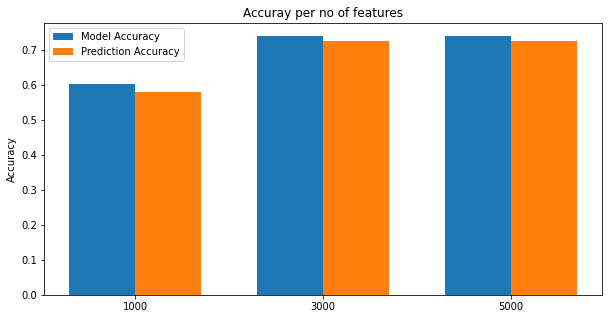

In [251]:
labels = n_features
train_acc = list(map(np.mean, results))
test_acc = accuracies

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10, 5))
rects1 = ax.bar(x - width/2, train_acc, width, label='Model Accuracy')
rects2 = ax.bar(x + width/2, test_acc, width, label='Prediction Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuray per no of features')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

With EventDescription, FailedAssets, CauseTechnical columns, multinomial NaivesBayes, the optimal number of features is 3000